In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame as df

import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [111]:
df_ = pd.read_csv('https://raw.githubusercontent.com/Datamanim/dataq/main/diamonds.csv', index_col=0)
df_.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


carat과 price의 경향을 비교하기 위한 scatterplot그래프를 출력하시오

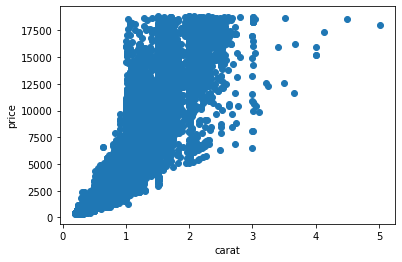

In [12]:
plt.scatter(df_.carat, df_.price)
plt.xlabel('carat')
plt.ylabel('price')
plt.show()

carat과 price사이의 상관계수와 상관계수의 p-value값은?

In [14]:
corr_val = df_.carat.corr(df_.price)
print(corr_val)

import scipy
from scipy import stats

corr_val_, p = stats.pearsonr(df_.carat, df_.price)
print(p)

0.9215913011934779
0.0


Diamond의 평균가격은 3932로 알려져있다. ‘H’ color를 가지는 다이아몬드 집단의 평균에 대한 일표본 t검정을 시행하려한다. 통계량과 pvalue값을 구하시오. 유의수준 0.05에서 귀무가설 채택여부를 boolean 값으로 표현할 변수(hypo) 만들고 출력하시오

In [24]:
H_diamonds = df_.loc[(df_.color=='H')]
statistic, p = stats.ttest_1samp(H_diamonds.price, 3932)

if p < 0.05:
    hypo = False
else:
    hypo = True
print(statistic, p, hypo)

11.988997411117696 7.569973305218302e-33 False


그래프상에서 ‘F’와 ‘G’는 평균이 유사해보인다.이를 확인하기 위해 집단간 등분산(levene,fligner,bartlett) 검정을 시행 후 결과를 출력하고조건에 맞는 독립표본 t검정을 시행하라

In [30]:
F_diamonds = df_.loc[(df_.color=='F')]
G_diamonds = df_.loc[(df_.color=='G')]

lev_test = stats.levene(F_diamonds.price, G_diamonds.price)
fli_test = stats.fligner(F_diamonds.price, G_diamonds.price)
bar_test = stats.bartlett(F_diamonds.price, G_diamonds.price)

print(lev_test)
print(fli_test)
print(bar_test)

# p value가 0.05 이하이므로, 집단 간 분산이 같지 않다.

FG_ttest = stats.ttest_ind(G_diamonds.price, F_diamonds.price, equal_var=False)
print(FG_ttest)

# p value가 0.05 이하이므로, 두 그룹의 평균은 같지 않다.

LeveneResult(statistic=53.627886257416655, pvalue=2.511093007074788e-13)
FlignerResult(statistic=37.04347553879807, pvalue=1.155244880009172e-09)
BartlettResult(statistic=47.52732212014331, pvalue=5.424264079257202e-12)
Ttest_indResult(statistic=5.045279980436125, pvalue=4.567032122704146e-07)


color ‘F’,’G’,’D’ 세집단의 price값들에 대해 anova분석을 시행하라.

In [40]:
D_diamonds = df_.loc[(df_.color=='D')]

lev_test = stats.levene(F_diamonds.price, G_diamonds.price, D_diamonds.price)
fli_test = stats.fligner(F_diamonds.price, G_diamonds.price, D_diamonds.price)
bar_test = stats.bartlett(F_diamonds.price, G_diamonds.price, D_diamonds.price)

print(lev_test)
print(fli_test)
print(bar_test)

#FG_KS = stats.kstest(F_diamonds.price, G_diamonds.price)
#FD_KS = stats.kstest(F_diamonds.price, D_diamonds.price)
#DG_KS = stats.kstest(D_diamonds.price, G_diamonds.price)
# 정규성 검증 실패

anova = stats.f_oneway(F_diamonds.price, G_diamonds.price, D_diamonds.price)
print(anova)

# 분산분석결과 p값이 0.05보다 작으므로, 귀무가설을 기각하고 유의수준 하에서 세 집단 중 어느 두 집단의 평균은 같지 않다.

LeveneResult(statistic=118.97521469312785, pvalue=3.557425577381817e-52)
FlignerResult(statistic=494.6459169558573, pvalue=3.881538382653629e-108)
BartlettResult(statistic=289.1436443252346, pvalue=1.6340125811454025e-63)
F_onewayResult(statistic=101.1811790316069, pvalue=1.6513790091285713e-44)


연속형 변수(carat,depth,table,price,x,y,z) 각각의 이상치(1,3분위값에서 IQR*1.5 외의 값) 갯수를 데이터 프레임(변수명 ratio_df, 비율의 내림차순 정렬)으로 아래와 같이 나타내어라.

In [48]:
df_outliers = df_.loc[:,['carat', 'depth', 'table', 'price', 'x', 'y', 'z']]
outliers_count = {}
for head in df_outliers.keys():
    count = 0
    Q1 = df_outliers[head].quantile(.25)
    Q3 = df_outliers[head].quantile(.75)
    IQR = Q3-Q1
    up_bound = Q3 + IQR*3/2
    dw_bound = Q1 - IQR*3/2
    for val in df_outliers[head]:
        if val > up_bound:
            count += 1
        elif val < dw_bound:
            count += 1
    outliers_count[head] = count

col_name, count = [], []
for key, value in outliers_count.items():
    col_name.append(key)
    count.append(value)

ratio_df = df({'column':col_name, 'count':count}).sort_values('count', ascending=False)
ratio_df

,column,count
3,price,3540
1,depth,2545
0,carat,1889
2,table,605
6,z,49
4,x,32
5,y,29


color에 따른 price의 max, min, 평균값을 colorDf 변수에 저장하고 아래와 같이 출력하는 코드를 작성하라

In [66]:
# print(df_.color.value_counts())
G_color = df_.loc[(df_.color=='G')]
E_color = df_.loc[(df_.color=='E')]
F_color = df_.loc[(df_.color=='F')]
H_color = df_.loc[(df_.color=='H')]
D_color = df_.loc[(df_.color=='D')]
I_color = df_.loc[(df_.color=='I')]
J_color = df_.loc[(df_.color=='J')]

G_val = ('G', G_color.price.max(), G_color.price.min(), G_color.price.mean())
E_val = ('E', E_color.price.max(), E_color.price.min(), E_color.price.mean())
F_val = ('F', F_color.price.max(), F_color.price.min(), F_color.price.mean())
H_val = ('H', H_color.price.max(), H_color.price.min(), H_color.price.mean())
D_val = ('D', D_color.price.max(), D_color.price.min(), D_color.price.mean())
I_val = ('I', I_color.price.max(), I_color.price.min(), I_color.price.mean())
J_val = ('J', J_color.price.max(), J_color.price.min(), J_color.price.mean())

vals = [G_val, E_val, F_val, H_val, D_val, I_val, J_val]
names, mins, maxs, means = [], [], [], []

for name, Max, Min, Mean in vals:
    names.append(name)
    maxs.append(Max)
    mins.append(Min)
    means.append(Mean)

colorDf = df({'color':names, 'max':maxs, 'min':mins, 'mean':means})
print(colorDf)

  color    max  min         mean
0     G  18818  354  3999.135671
1     E  18731  326  3076.752475
2     F  18791  342  3724.886397
3     H  18803  337  4486.669196
4     D  18693  357  3169.954096
5     I  18823  334  5091.874954
6     J  18710  335  5323.818020


전체 데이터중 color의 발생빈도수에 따라 labelEncoding(빈도수 적은것 : 1, 빈도수 증가할수록 1씩증가)을 하고 colorLabel 컬럼에 저장하고 cut에 따른 colorLabel의 평균값을 구하여라

In [112]:
from sklearn.preprocessing import OrdinalEncoder
G_count = len(G_color.index)
E_count = len(E_color.index)
F_count = len(F_color.index)
H_count = len(H_color.index)
D_count = len(D_color.index)
I_count = len(I_color.index)
J_count = len(J_color.index)

df_['colorLabel'] = 0
df_.loc[(df_.color=='G'), 'colorLabel'] = G_count
df_.loc[(df_.color=='E'), 'colorLabel'] = E_count
df_.loc[(df_.color=='F'), 'colorLabel'] = F_count
df_.loc[(df_.color=='H'), 'colorLabel'] = H_count
df_.loc[(df_.color=='D'), 'colorLabel'] = D_count
df_.loc[(df_.color=='I'), 'colorLabel'] = I_count
df_.loc[(df_.color=='J'), 'colorLabel'] = J_count
# df_.head()

encoder = LabelEncoder()
np_colorLabel = np.array(df_.colorLabel)
df_['colorLabel'] = encoder.fit_transform(np_colorLabel.reshape(-1,1))
# df_.head()
#print(encoder.inverse_transform([5]))
ideal_cut = df_.loc[(df_.cut == 'Ideal')]
premium_cut = df_.loc[(df_.cut=='Premium')]
very_cut = df_.loc[(df_.cut=='Very Good')]
good_cut = df_.loc[(df_.cut=='Good')]
fair_cut = df_.loc[(df_.cut=='Fair')]

print('ideal ', ideal_cut.colorLabel.mean())
print('premium ', premium_cut.colorLabel.mean())
print('very good ', very_cut.colorLabel.mean())
print('good ', good_cut.colorLabel.mean())
print('fair ', fair_cut.colorLabel.mean())

ideal  3.769152243515382
premium  3.644913349285766
very good  3.654361860619103
good  3.562780269058296
fair  3.5167701863354037


C:\Users\fogbo\anaconda3\envs\first_env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


price의 값에 따른 구간을 1000단위로 나누고 priceLabel 컬럼에 저장하라. 저장시 숫자 순으로 label하고(0~1000이하 : 0,1000초과~2000미만 :1 …) 최종적으로 구간별 갯수(변수명:labelCount)를 출력하라

In [114]:
from sklearn.preprocessing import LabelBinarizer, Binarizer, KBinsDiscretizer

df_['priceLabel'] = 18
for i in range(17, -1, -1):
    df_.loc[(df_.price < (i+1)*1000), 'priceLabel'] = i

df_.priceLabel.value_counts()

0     14499
1      9704
2      6131
4      4653
3      4226
5      3174
6      2278
7      1669
8      1307
9      1076
10      935
11      824
12      702
13      603
15      514
14      503
16      424
17      406
18      312
Name: priceLabel, dtype: int64